In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib
%matplotlib notebook
import pandas as pd

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter(x, y, bins=50, xlim=None, ylim=None, filename=None):
    fig = plt.figure(figsize=(10, 10))
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
import matplotlib.animation as animation

In [53]:
def get_image_data(filename, gamma=0.6, debug=False, hide_max=False, logscale=False):
    
    extent = None
    image_size = None
    with open(filename, 'r') as f:
        header0 = f.readline().strip()
        header1 = f.readline().strip()
        header2 = f.readline().strip()

        _s = re.split('\(|\,|\)', header0)
        _x = re.split('\(|\,|\)', header1)
        _y = re.split('\(|\,|\)', header2)
        image_size = [int(_s[1]),int(_s[2])]
        extent = [float(_x[1]),float(_x[2]),float(_y[1]),float(_y[2])]
    image = np.loadtxt(filename).reshape(image_size)
    if (debug):
        _all = image.shape[0] * image.shape[1]
        _z = image[image == 0].shape[0]
        print(f"{filename}")
        print(f"\tzeros: {_z} ({100 * _z/_all}%)")
        print(f"\tmean & std: {np.mean(image)} +- {np.std(image)}")
        print(f"\ttotal_rays: {np.sum(image)}")
    
    img = np.zeros_like(image)
    if gamma is not None:
        img[image > 0] = image[image > 0]**gamma
    if logscale is not None and logscale:
        img[image > 0] = np.log10(image[image > 0])
    if img[img == np.max(img)].shape[0] < 5 and hide_max:
        img[img == np.max(img)] = np.mean(img) # removing center-of-mass pixel with extreame amplification
    return img, extent

def get_lc_data(filename):
    data = np.loadtxt(filename)
    return pd.DataFrame(data=data.copy(), columns=["y1", "y2", "n_ad", "a_ad",  "n_gs", "a_gs",  "n_ld", "a_ld", "n_pl", "a_pl"])

In [171]:
rays_y = np.loadtxt("./output/test/rays_0.00.dat")

<IPython.core.display.Javascript object>


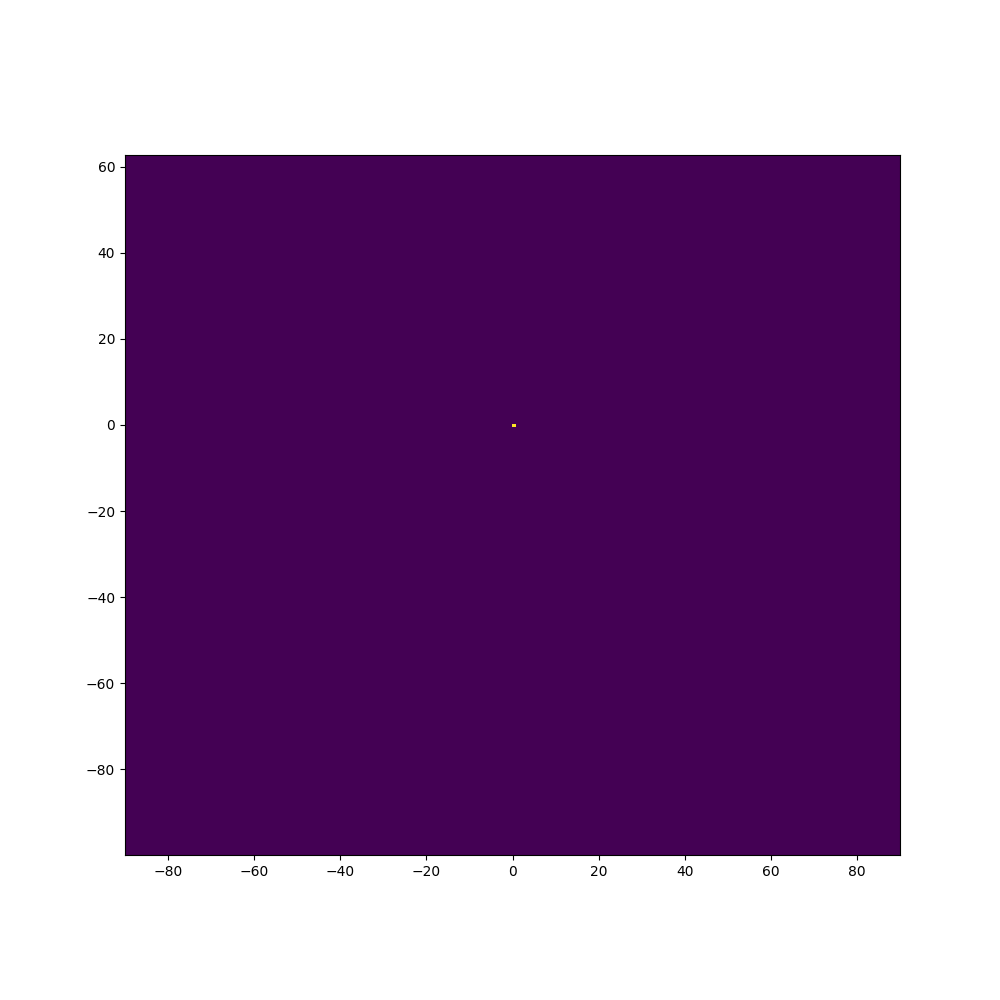

In [172]:
m = np.logical_and(np.abs(rays_y[:,0]) <= 100, np.abs(rays_y[:,1]) <= 100)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])

output/test/image_0.00.dat
	zeros: 504964 (50.4964%)
	mean & std: 50.264787 +- 52.34491456526251
	total_rays: 50264787.0
output/test/image_0.00.dat
	zeros: 504964 (50.4964%)
	mean & std: 50.264787 +- 52.34491456526251
	total_rays: 50264787.0


<IPython.core.display.Javascript object>


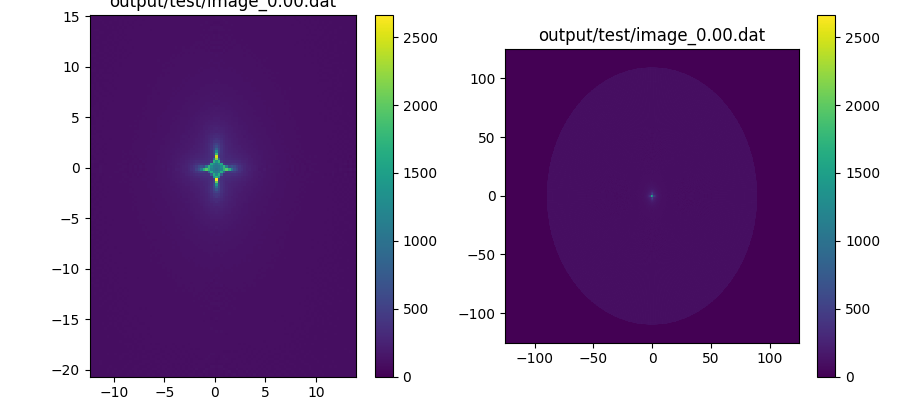

In [38]:
filename1 = "output/test/image_0.00.dat"
filename2 = "output/test/image_0.00.dat"

img1, extent1 = get_image_data(filename1, gamma=1, debug=True)
img2, extent2 = get_image_data(filename2, gamma=1, debug=True)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='none', extent=extent1, origin='lower')
pos2 = ax2.imshow(img2, interpolation='none', extent=extent2, origin='lower')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.colorbar(pos2, ax=ax2)
fig.tight_layout()
plt.show()

output/reference/image_0.00.dat
	zeros: 500668 (50.0668%)
	mean & std: 0.664888 +- 0.8913977492993798
	total_rays: 664888.0


<IPython.core.display.Javascript object>


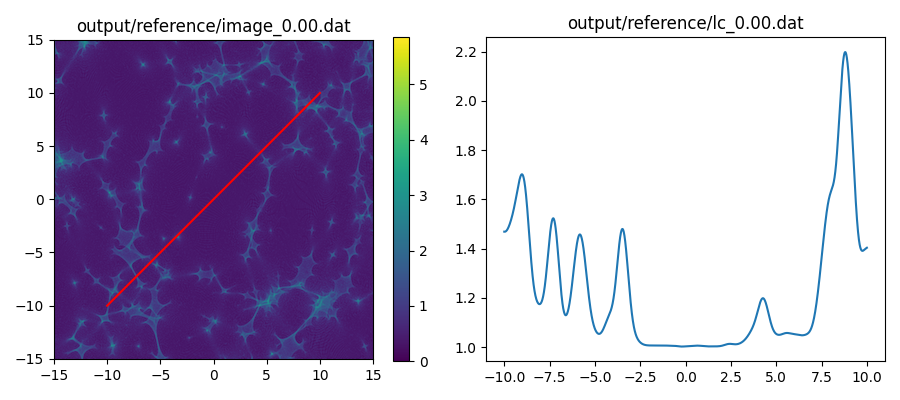

In [70]:
filename1 = "output/reference/image_0.00.dat"
filename2 = "output/reference/lc_0.00.dat"

img1, extent1 = get_image_data(filename1, gamma=0.6, debug=True)
lc = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
ax1.plot(lc['y1'], lc['y2'], color='red')
pos2 = ax2.plot(lc['y1'], lc['ampl']/lc['norm'], '-')
#pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
#pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


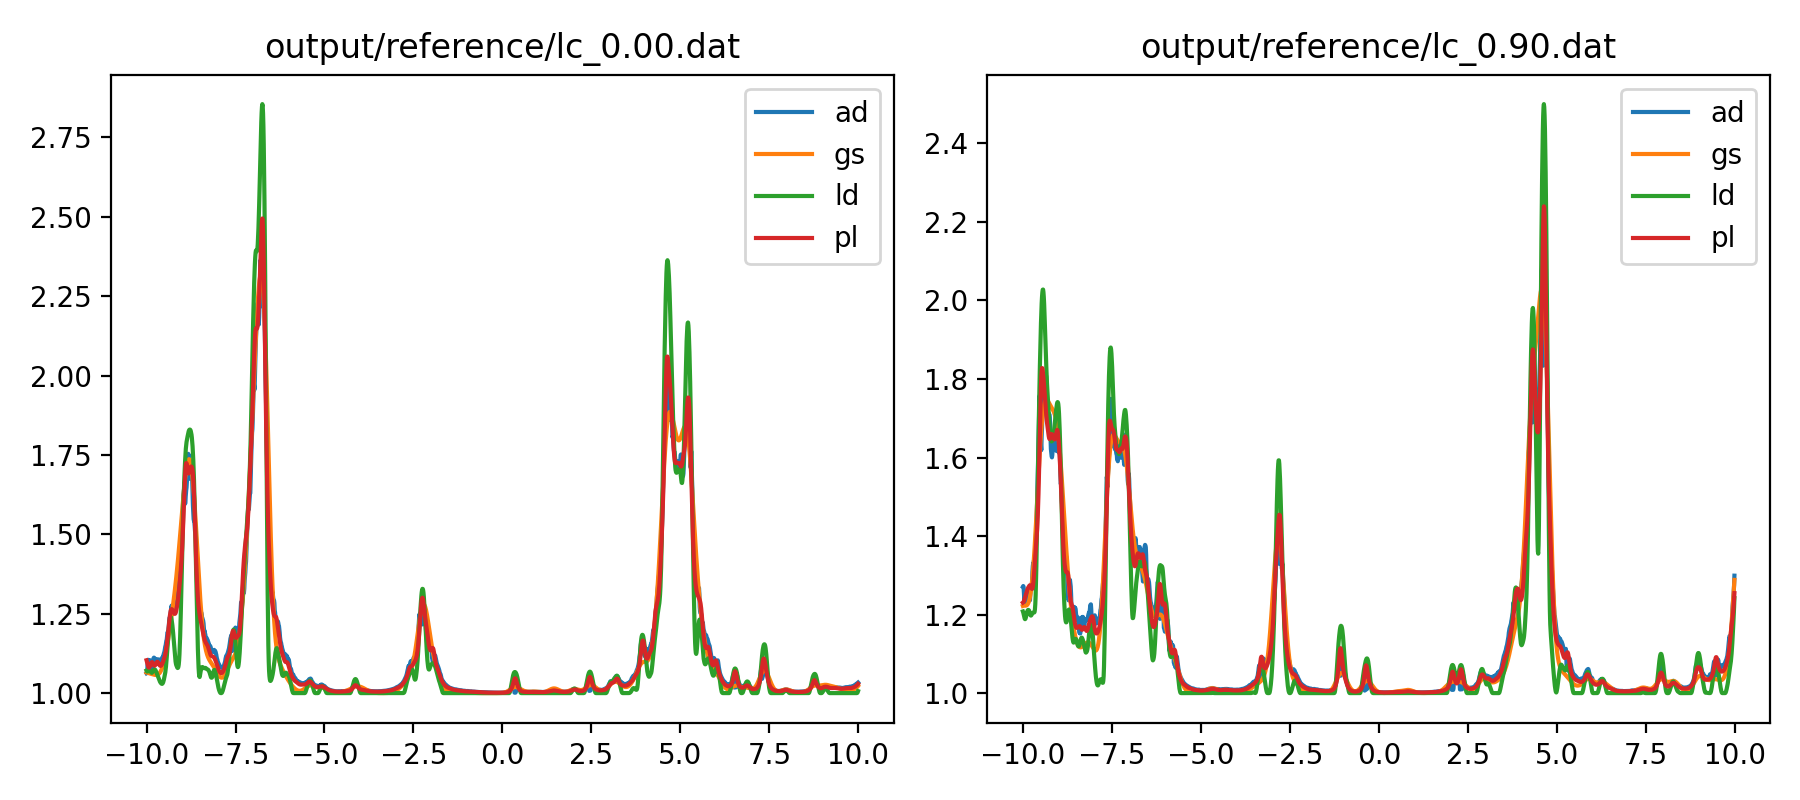

In [66]:
filename1 = "output/reference/lc_0.00.dat"
filename2 = "output/reference/lc_0.90.dat"

lc1 = get_lc_data(filename1)
lc2 = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.plot(lc1['y1'], lc1['a_ad']/lc1['n_ad'], '-', label='ad')
ax1.plot(lc1['y1'], lc1['a_gs']/lc1['n_gs'], '-', label='gs')
ax1.plot(lc1['y1'], lc1['a_ld']/lc1['n_ld'], '-', label='ld')
ax1.plot(lc1['y1'], lc1['a_pl']/lc1['n_pl'], '-', label='pl')
ax1.legend()

pos2 = ax2.plot(lc2['y1'], lc2['a_ad']/lc2['n_ad'], '-', label='ad')
ax2.plot(lc2['y1'], lc2['a_gs']/lc2['n_gs'], '-', label='gs')
ax2.plot(lc2['y1'], lc2['a_ld']/lc2['n_ld'], '-', label='ld')
ax2.plot(lc2['y1'], lc2['a_pl']/lc2['n_pl'], '-', label='pl')
ax2.legend()

ax1.set_title(filename1)
ax2.set_title(filename2)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


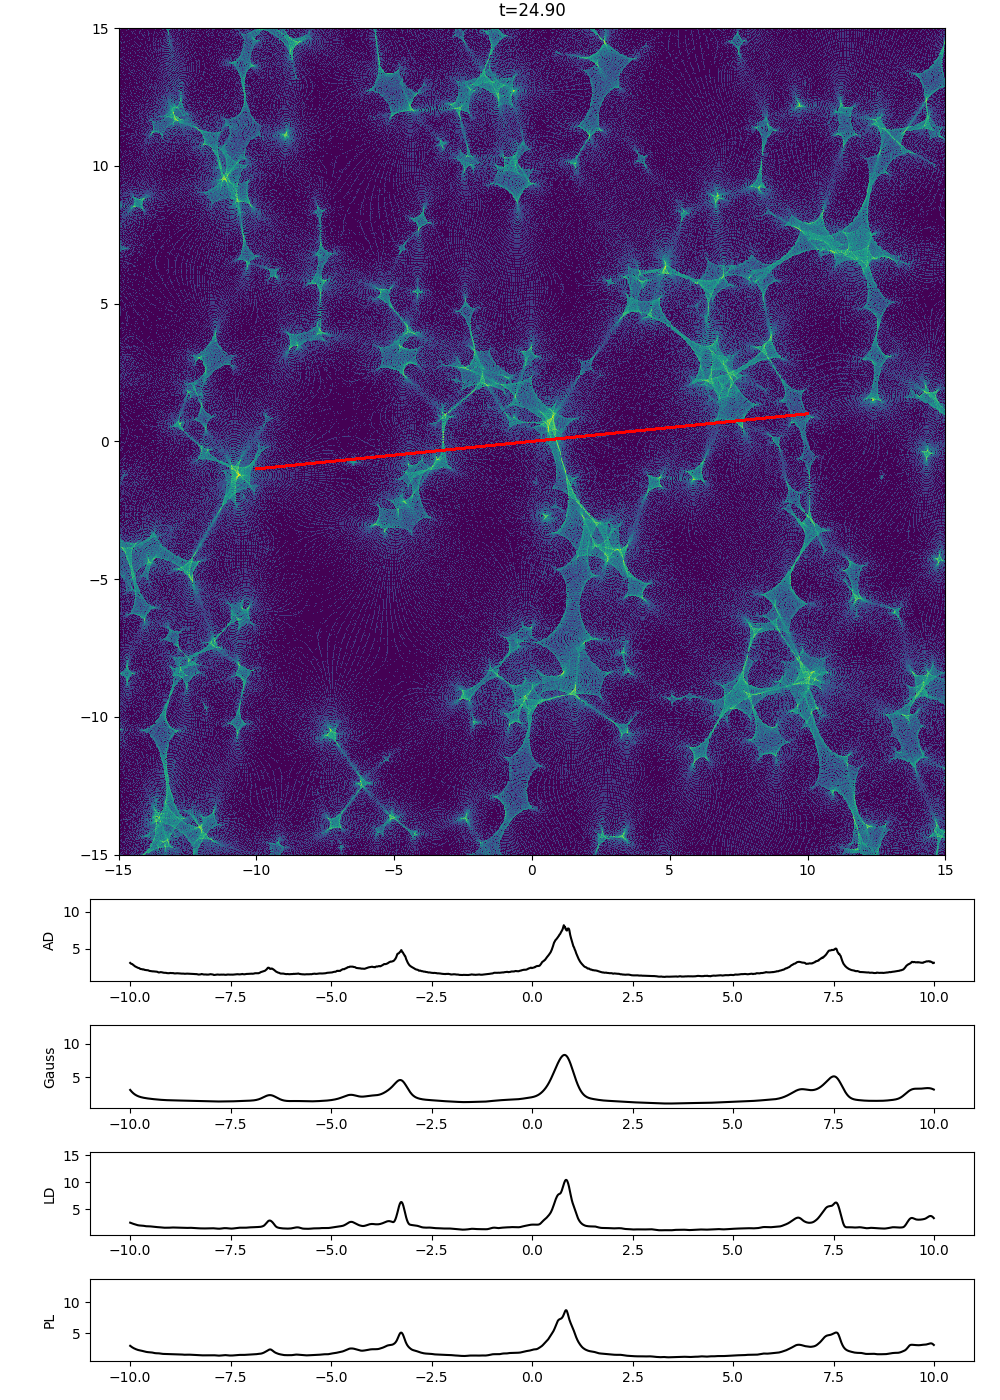

t=0.00
t=0.10
t=0.20
t=0.30
t=0.40
t=0.50
t=0.60
t=0.70
t=0.80
t=0.90
t=1.00
t=1.10
t=1.20
t=1.30
t=1.40
t=1.50
t=1.60
t=1.70
t=1.80
t=1.90
t=2.00
t=2.10
t=2.20
t=2.30
t=2.40
t=2.50
t=2.60
t=2.70
t=2.80
t=2.90
t=3.00
t=3.10
t=3.20
t=3.30
t=3.40
t=3.50
t=3.60
t=3.70
t=3.80
t=3.90
t=4.00
t=4.10
t=4.20
t=4.30
t=4.40
t=4.50
t=4.60
t=4.70
t=4.80
t=4.90
t=5.00
t=5.10
t=5.20
t=5.30
t=5.40
t=5.50
t=5.60
t=5.70
t=5.80
t=5.90
t=6.00
t=6.10
t=6.20
t=6.30
t=6.40
t=6.50
t=6.60
t=6.70
t=6.80
t=6.90
t=7.00
t=7.10
t=7.20
t=7.30
t=7.40
t=7.50
t=7.60
t=7.70
t=7.80
t=7.90
t=8.00
t=8.10
t=8.20
t=8.30
t=8.40
t=8.50
t=8.60
t=8.70
t=8.80
t=8.90
t=9.00
t=9.10
t=9.20
t=9.30
t=9.40
t=9.50
t=9.60
t=9.70
t=9.80
t=9.90
t=10.00
t=10.10
t=10.20
t=10.30
t=10.40
t=10.50
t=10.60
t=10.70
t=10.80
t=10.90
t=11.00
t=11.10
t=11.20
t=11.30
t=11.40
t=11.50
t=11.60
t=11.70
t=11.80
t=11.90
t=12.00
t=12.10
t=12.20
t=12.30
t=12.40
t=12.50
t=12.60
t=12.70
t=12.80
t=12.90
t=13.00
t=13.10
t=13.20
t=13.30
t=13.40
t=13.50
t=13.60
t=13

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(10, 14), gridspec_kw={'height_ratios': [10, 1, 1, 1, 1]})
fig.tight_layout()
fig.subplots_adjust(left=0.09, top=0.98)

ims = []
max_ampl = []
s_ad_max = 0
s_gs_max = 0
s_ld_max = 0
s_pl_max = 0
for t in np.arange(0, 25, 0.1):
    print("t=%.2f" % t)
    filename1 = "output/test/image_%.2f.dat" % t
    filename2 = "output/test/lc_%.2f.dat" % t
    img, extent = get_image_data(filename1, logscale=True)
    lc = get_lc_data(filename2)
    title = ax1.text(0.5,1.01, "t=%.2f" % t, ha="center",va="bottom", transform=ax1.transAxes, fontsize="large")
    line1 = ax1.imshow(img, interpolation='none', extent=extent, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    
    s_ad = lc['a_ad']/lc['n_ad']
    line2, = ax2.plot(lc['y1'], s_ad, '-', color='black')
    ax2.set_ylabel('AD')
    if max(s_ad) > s_ad_max: s_ad_max = max(s_ad)
        
    s_gs = lc['a_gs']/lc['n_gs']
    line3, = ax3.plot(lc['y1'], s_gs, '-', color='black')
    ax3.set_ylabel('Gauss')
    if max(s_gs) > s_gs_max: s_gs_max = max(s_gs)

    s_ld = lc['a_ld']/lc['n_ld']
    line4, = ax4.plot(lc['y1'], s_ld, '-', color='black')
    ax4.set_ylabel('LD')
    if max(s_ld) > s_ld_max: s_ld_max = max(s_ld)

    s_pl = lc['a_pl']/lc['n_pl']
    line5, = ax5.plot(lc['y1'], s_pl, '-', color='black')
    ax5.set_ylabel('PL')
    if max(s_pl) > s_pl_max: s_pl_max = max(s_ld)

    ims.append([line1, line2, line3, line4, line5, title])

for l in ims:
    _l1, _l2, _l3, _l4, _l5, _t = l
    _l2.axes.set_ylim([None, 1.05 * s_ad_max])
    _l3.axes.set_ylim([None, 1.05 * s_gs_max])
    _l4.axes.set_ylim([None, 1.05 * s_ld_max])
    _l5.axes.set_ylim([None, 1.05 * s_pl_max])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=False)
ani.save('images/dynamic_images.mp4')
plt.show()